# DINOv3 Restaurant Table Classification - V2

**Task:** Classify CCTV crops of restaurant tables as: `clean`, `dirty`, or `occupied`

**Architecture:** Frozen DINOv3 backbone → CLS token + Attention-Pooled Patches → MLP Head

**V2 Changes:**
- Lower weight decay (0.01 vs 0.05) - less aggressive for small head
- Higher dropout (0.5 vs 0.4) - more regularization
- 2x dirty class weight boost - prioritize minority class

**Key Features:**
- Group-based train/val/test split (prevents data leakage from consecutive CCTV frames)
- Attention pooling learns which patches matter (vs mean pooling)
- Focal loss + boosted class weights for imbalanced data

**Requirements:** Python 3.10+ (DINOv3 uses modern type hints)

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from PIL import Image
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoImageProcessor

import warnings
warnings.filterwarnings('ignore')

import sys
print(f"Python version: {sys.version}")

Python version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.4.4.1)]


In [2]:
# =============================================================================
# CONFIGURATION - V2 (tuned hyperparameters)
# =============================================================================

DATA_DIR = "../data"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

DINOV3_MODELS = {
    "small": "dinov3_vits16",
    "base": "dinov3_vitb16",
    "large": "dinov3_vitl16",
    "huge": "dinov3_vith16plus",
}
EMBED_DIMS = {"small": 384, "base": 768, "large": 1024, "huge": 1280}

BACKBONE_SIZE = "base"

BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01  # Reduced from 0.05 - less aggressive for small head
WARMUP_RATIO = 0.1
LABEL_SMOOTHING = 0.05
EARLY_STOPPING_PATIENCE = 10
DROPOUT = 0.5  # Increased from 0.4 - more regularization

FOCAL_LOSS_GAMMA = 2.0
USE_CLASS_WEIGHTS = True
DIRTY_WEIGHT_BOOST = 2.0  # Extra boost for dirty class

AUGMENTATION = "aggressive"

# Mixup settings
USE_MIXUP = True
MIXUP_ALPHA = 0.2

# Attention pooling (vs mean pooling)
USE_ATTN_POOL = True

SEED = 42
NUM_WORKERS = 0

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
# Load DINOv3 from HuggingFace (Meta's URL is returning 403)
from transformers import AutoModel

print(f"Loading DINOv3 {BACKBONE_SIZE} from HuggingFace...")

HF_MODELS = {
    "small": "facebook/dinov3-vits16-pretrain-lvd1689m",
    "base": "facebook/dinov3-vitb16-pretrain-lvd1689m",
    "large": "facebook/dinov3-vitl16-pretrain-lvd1689m",
}

backbone = AutoModel.from_pretrained(HF_MODELS[BACKBONE_SIZE], trust_remote_code=True)

embed_dim = EMBED_DIMS[BACKBONE_SIZE]
print(f"Embed dim: {embed_dim}")
print(f"Backbone params: {sum(p.numel() for p in backbone.parameters()):,}")

Loading DINOv3 base from HuggingFace...
Embed dim: 768
Backbone params: 85,660,416


In [5]:
full_dataset = datasets.ImageFolder(root=DATA_DIR)
num_classes = len(full_dataset.classes)
id2label = {i: c for i, c in enumerate(full_dataset.classes)}
label2id = {c: i for i, c in id2label.items()}

print(f"Classes: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")

class_counts = Counter(full_dataset.targets)
print("\nClass distribution:")
for idx, count in sorted(class_counts.items()):
    print(f"  {id2label[idx]}: {count} ({100*count/len(full_dataset):.1f}%)")

Classes: ['clean', 'dirty', 'occupied']
Total images: 891

Class distribution:
  clean: 231 (25.9%)
  dirty: 106 (11.9%)
  occupied: 554 (62.2%)


In [6]:
from sklearn.model_selection import GroupShuffleSplit
import os

def get_group_id(filepath):
    """Extract session+table group from filename to prevent data leakage.
    
    Filename format: IPC3_40a0f14d_3_1_Mimosas_IPC3_20251227113907_table_00_frame_0001_00m30s.jpg
    Group = session_id + timestamp + table_num
    
    For files without this format (e.g., "20.JPG"), use the filename itself as group.
    """
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    
    # Check if it matches the expected format (has enough parts and contains "table")
    if len(parts) >= 8 and 'table' in filename:
        session_id = parts[1]      # 40a0f14d
        timestamp = parts[5]       # 20251227113907
        table = parts[6] + '_' + parts[7]  # table_00
        return f"{session_id}_{timestamp}_{table}"
    else:
        # For other filename formats, use the filename as its own group
        return filename

# Get indices and labels
indices = list(range(len(full_dataset)))
labels = full_dataset.targets

# Extract group for each sample
groups = [get_group_id(full_dataset.samples[i][0]) for i in indices]
unique_groups = set(groups)
print(f"Found {len(unique_groups)} unique session+table groups across {len(indices)} images")

# Group-based split: all images from same session+table go to same split
gss_train = GroupShuffleSplit(n_splits=1, test_size=(VAL_RATIO + TEST_RATIO), random_state=SEED)
train_idx, temp_idx = next(gss_train.split(indices, labels, groups))
train_idx, temp_idx = list(train_idx), list(temp_idx)

# Split temp into val/test (also group-based)
temp_groups = [groups[i] for i in temp_idx]
temp_labels = [labels[i] for i in temp_idx]
gss_valtest = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO/(VAL_RATIO+TEST_RATIO), random_state=SEED)
val_idx_rel, test_idx_rel = next(gss_valtest.split(range(len(temp_idx)), temp_labels, temp_groups))
val_idx = [temp_idx[i] for i in val_idx_rel]
test_idx = [temp_idx[i] for i in test_idx_rel]

print(f"Train: {len(train_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")

# Verify no group leakage
train_groups = set(groups[i] for i in train_idx)
val_groups = set(groups[i] for i in val_idx)
test_groups = set(groups[i] for i in test_idx)
assert len(train_groups & val_groups) == 0, "Leakage between train and val!"
assert len(train_groups & test_groups) == 0, "Leakage between train and test!"
assert len(val_groups & test_groups) == 0, "Leakage between val and test!"
print("✓ No group leakage detected - splits are clean!")

# Class weights for imbalanced data
train_labels = [labels[i] for i in train_idx]
train_class_counts = Counter(train_labels)
class_weights = torch.tensor([len(train_labels)/(num_classes*train_class_counts[i]) for i in range(num_classes)], dtype=torch.float32).to(device)

# Boost dirty class weight
dirty_idx = label2id['dirty']
print(f"Original dirty weight: {class_weights[dirty_idx].item():.2f}")
class_weights[dirty_idx] *= DIRTY_WEIGHT_BOOST
print(f"Boosted dirty weight: {class_weights[dirty_idx].item():.2f} (x{DIRTY_WEIGHT_BOOST})")

sample_weights = [class_weights[labels[i]].item() for i in train_idx]
print(f"Class weights: {class_weights.tolist()}")

Found 29 unique session+table groups across 891 images
Train: 669 | Val: 166 | Test: 56
✓ No group leakage detected - splits are clean!
Original dirty weight: 2.90
Boosted dirty weight: 5.79 (x2.0)
Class weights: [1.3195266723632812, 5.792207717895508, 0.5271867513656616]


In [7]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

class DINOv3Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, augment="none"):
        self.dataset = dataset
        self.indices = indices
        self.normalize = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
        if augment == "standard":
            self.augment = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), transforms.RandomRotation(10), transforms.ColorJitter(0.3, 0.3, 0.2), transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
        elif augment == "aggressive":
            self.augment = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.6, 1.0)), transforms.RandomRotation(15), transforms.ColorJitter(0.4, 0.4, 0.3, 0.1), transforms.RandomGrayscale(0.1), transforms.GaussianBlur(3), transforms.ToTensor(), transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])
        else:
            self.augment = None
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if img.mode != "RGB": img = img.convert("RGB")
        return (self.augment or self.normalize)(img), label

train_ds = DINOv3Dataset(full_dataset, train_idx, augment=AUGMENTATION)
val_ds = DINOv3Dataset(full_dataset, val_idx)
test_ds = DINOv3Dataset(full_dataset, test_idx)

sampler = WeightedRandomSampler(sample_weights, len(train_idx), replacement=True)
train_loader = DataLoader(train_ds, BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
print(f"Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

Batches - Train: 41 | Val: 11 | Test: 4


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.alpha, self.gamma, self.label_smoothing = alpha, gamma, label_smoothing
    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce)
        fl = (1-pt)**self.gamma * ce
        return (self.alpha[targets] * fl if self.alpha is not None else fl).mean()

def mixup_data(x, y, alpha=0.2):
    """Mixup: blend pairs of images and labels"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute loss for mixup"""
    return lam * F.cross_entropy(pred, y_a) + (1 - lam) * F.cross_entropy(pred, y_b)

In [9]:
class AttentionPool(nn.Module):
    """Learn which patches matter - finds local discriminative features.
    
    Unlike mean pooling which treats all patches equally, this learns to
    focus on discriminative regions (e.g., dishes/debris for 'dirty' class).
    """
    def __init__(self, dim, hidden=128):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    
    def forward(self, x):  # x: [B, N, D] (batch, num_patches, embed_dim)
        weights = F.softmax(self.attn(x), dim=1)  # [B, N, 1]
        return (weights * x).sum(dim=1)  # [B, D]


class DINOv3Classifier(nn.Module):
    def __init__(self, backbone, embed_dim, num_classes, head_type="3layer", dropout=0.3, use_attn_pool=True):
        super().__init__()
        self.backbone = backbone
        for p in backbone.parameters(): p.requires_grad = False
        backbone.eval()
        
        # Attention pooling for patches (CLS token kept separate)
        self.use_attn_pool = use_attn_pool
        if use_attn_pool:
            self.attn_pool = AttentionPool(embed_dim)
        
        # Feature dim = CLS (embed_dim) + pooled patches (embed_dim)
        feat_dim = embed_dim * 2
        if head_type == "linear":
            self.head = nn.Sequential(nn.LayerNorm(feat_dim), nn.Dropout(dropout), nn.Linear(feat_dim, num_classes))
        elif head_type == "2layer":
            self.head = nn.Sequential(nn.LayerNorm(feat_dim), nn.Linear(feat_dim, 256), nn.GELU(), nn.Dropout(dropout), nn.Linear(256, num_classes))
        else:  # 3layer
            self.head = nn.Sequential(nn.LayerNorm(feat_dim), nn.Linear(feat_dim, 512), nn.GELU(), nn.Dropout(dropout), nn.Linear(512, 128), nn.GELU(), nn.Dropout(dropout), nn.Linear(128, num_classes))
        self.head_type, self.embed_dim = head_type, embed_dim
    
    def forward(self, x):
        with torch.no_grad():
            out = self.backbone(x)
            if hasattr(out, 'last_hidden_state'):
                cls_token = out.last_hidden_state[:, 0]
                patches = out.last_hidden_state[:, 1:]
            else:
                cls_token = out['x_norm_clstoken']
                patches = out['x_norm_patchtokens']
        
        # CLS keeps full weight, patches get attention-pooled (or mean-pooled as fallback)
        if self.use_attn_pool:
            pooled = self.attn_pool(patches)
        else:
            pooled = patches.mean(dim=1)
        
        features = torch.cat([cls_token, pooled], dim=1)
        return self.head(features)
    
    def train(self, mode=True):
        super().train(mode)
        self.backbone.eval()  # Keep backbone frozen
        return self

In [10]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience, self.counter, self.best_score, self.best_state = patience, 0, None, None
    def __call__(self, val_acc, model):
        if self.best_score is None or val_acc > self.best_score + 0.001:
            self.best_score, self.best_state, self.counter = val_acc, {k: v.cpu().clone() for k, v in model.state_dict().items()}, 0
        else:
            self.counter += 1
        return self.counter >= self.patience

def train_epoch(model, loader, criterion, optimizer, scheduler, device, use_mixup=False, mixup_alpha=0.2):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        if use_mixup:
            x, y_a, y_b, lam = mixup_data(x, y, mixup_alpha)
            logits = model(x)
            loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            # For accuracy, use the dominant label
            correct += (lam * (logits.argmax(1) == y_a).float() + (1-lam) * (logits.argmax(1) == y_b).float()).sum().item()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            correct += (logits.argmax(1) == y).sum().item()
        
        loss.backward()
        # Clip gradients for all trainable params (head + attn_pool)
        trainable_params = list(model.head.parameters())
        if hasattr(model, 'attn_pool') and model.use_attn_pool:
            trainable_params += list(model.attn_pool.parameters())
        torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        total += y.size(0)
    return total_loss/len(loader), correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total, preds, labels = 0, 0, 0, [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_loss += criterion(logits, y).item()
        p = logits.argmax(1)
        correct += (p == y).sum().item()
        total += y.size(0)
        preds.extend(p.cpu().numpy())
        labels.extend(y.cpu().numpy())
    return total_loss/len(loader), correct/total, preds, labels

In [11]:
def train_model(model, train_loader, val_loader, config, device):
    model = model.to(device)
    criterion = FocalLoss(class_weights if USE_CLASS_WEIGHTS else None, FOCAL_LOSS_GAMMA, LABEL_SMOOTHING)
    
    # Collect all trainable parameters (head + attention pooling if used)
    trainable_params = list(model.head.parameters())
    if hasattr(model, 'attn_pool') and model.use_attn_pool:
        trainable_params += list(model.attn_pool.parameters())
    
    optimizer = torch.optim.AdamW(trainable_params, lr=config['lr'], weight_decay=config['weight_decay'])
    total_steps = len(train_loader) * config['epochs']
    warmup_steps = int(WARMUP_RATIO * total_steps)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda s: s/warmup_steps if s < warmup_steps else 0.5*(1+np.cos(np.pi*(s-warmup_steps)/(total_steps-warmup_steps))))
    early_stopping = EarlyStopping(EARLY_STOPPING_PATIENCE)
    
    for epoch in range(config['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, 
                                            use_mixup=USE_MIXUP, mixup_alpha=MIXUP_ALPHA)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}: train_acc={100*train_acc:.1f}% val_acc={100*val_acc:.1f}%")
        if early_stopping(val_acc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break
    model.load_state_dict(early_stopping.best_state)
    return model.to(device), early_stopping.best_score

In [12]:
# Train
model = DINOv3Classifier(backbone, embed_dim, num_classes, head_type="3layer", dropout=DROPOUT, use_attn_pool=USE_ATTN_POOL)
print(f"Model config: dropout={DROPOUT}, use_attn_pool={USE_ATTN_POOL}")
config = {'epochs': NUM_EPOCHS, 'lr': LEARNING_RATE, 'weight_decay': WEIGHT_DECAY}
model, best_acc = train_model(model, train_loader, val_loader, config, device)
print(f"\nBest val accuracy: {100*best_acc:.2f}%")

Model config: dropout=0.5, use_attn_pool=True


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1: train_acc=37.0% val_acc=13.9%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2: train_acc=57.3% val_acc=43.4%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3: train_acc=77.9% val_acc=81.3%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4: train_acc=80.7% val_acc=83.1%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5: train_acc=88.2% val_acc=82.5%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6: train_acc=89.9% val_acc=87.3%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7: train_acc=89.7% val_acc=89.2%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8: train_acc=89.8% val_acc=89.2%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9: train_acc=88.6% val_acc=84.9%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10: train_acc=87.9% val_acc=88.6%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11: train_acc=93.3% val_acc=88.6%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12: train_acc=92.2% val_acc=88.0%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13: train_acc=91.5% val_acc=90.4%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14: train_acc=90.4% val_acc=88.0%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15: train_acc=89.6% val_acc=84.3%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16: train_acc=90.7% val_acc=86.7%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17: train_acc=92.1% val_acc=89.8%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18: train_acc=90.3% val_acc=88.6%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19: train_acc=92.0% val_acc=89.2%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20: train_acc=93.3% val_acc=88.6%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21: train_acc=92.4% val_acc=91.0%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22: train_acc=91.1% val_acc=88.6%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23: train_acc=89.9% val_acc=88.6%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24: train_acc=91.7% val_acc=89.8%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25: train_acc=94.0% val_acc=90.4%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26: train_acc=92.1% val_acc=89.2%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27: train_acc=93.0% val_acc=89.8%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28: train_acc=93.4% val_acc=88.0%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29: train_acc=92.7% val_acc=88.0%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30: train_acc=91.9% val_acc=88.0%


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31: train_acc=89.9% val_acc=89.2%
Early stopping at epoch 31

Best val accuracy: 90.96%


Test Accuracy: 89.29%

              precision    recall  f1-score   support

       clean       0.45      1.00      0.62         5
       dirty       1.00      0.25      0.40         8
    occupied       1.00      1.00      1.00        43

    accuracy                           0.89        56
   macro avg       0.82      0.75      0.67        56
weighted avg       0.95      0.89      0.88        56



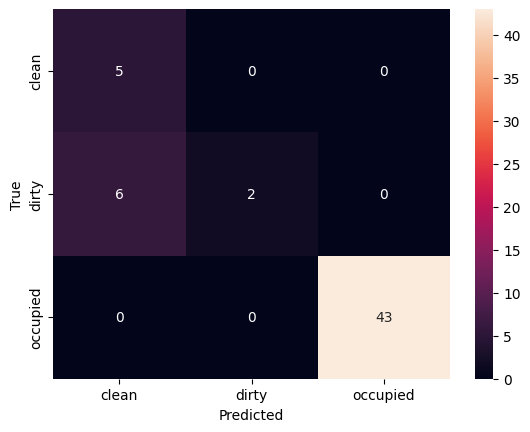

In [13]:
# Test
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

criterion = FocalLoss(class_weights, FOCAL_LOSS_GAMMA)
_, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {100*test_acc:.2f}%\n")
print(classification_report(labels, preds, target_names=list(id2label.values())))

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [14]:
# Save
save_dict = {
    'head': model.head.state_dict(),
    'backbone': DINOV3_MODELS[BACKBONE_SIZE],
    'embed_dim': embed_dim,
    'id2label': id2label,
    'use_attn_pool': USE_ATTN_POOL,
}
if USE_ATTN_POOL and hasattr(model, 'attn_pool'):
    save_dict['attn_pool'] = model.attn_pool.state_dict()
torch.save(save_dict, 'dinov3_classifier.pt')
print("Model saved to dinov3_classifier.pt")

Model saved to dinov3_classifier.pt
